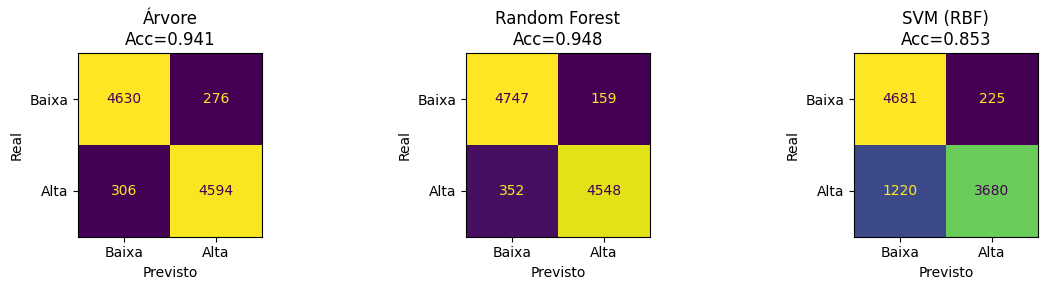

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1) Dados
df = pd.read_csv("SolarPrediction.csv")
thr = df["Radiation"].median()
y = (df["Radiation"] > thr).astype(int)

# Features: remove alvo e colunas temporais; fica só numéricas
drop_cols = ["Radiation", "Time", "Data", "TimeSunRise", "TimeSunSet"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number]).copy()

# Sanitização simples
mask = X.notna().all(axis=1)
X, y = X[mask], y[mask]

# 2) Split 70/30
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 3) Modelos (SVM com escala; árvores não precisam)
modelos = {
    "Árvore": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", C=1.0, gamma="scale"))
    ])
}

# 4) Treino, avaliação e matrizes de confusão (enxuto)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for ax, (nome, mdl) in zip(axes, modelos.items()):
    mdl.fit(X_tr, y_tr)
    y_pred = mdl.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    cm = confusion_matrix(y_te, y_pred, labels=[0, 1])

    disp = ConfusionMatrixDisplay(cm, display_labels=["Baixa", "Alta"])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"{nome}\nAcc={acc:.3f}")
    ax.set_xlabel("Previsto"); ax.set_ylabel("Real")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1) Carregar dados
df = pd.read_csv("T1.csv")

# Alvo típico do SCADA eólico (kW); ajuste o nome se o seu CSV diferir
target_col = "LV ActivePower (kW)"
assert target_col in df.columns, f"Coluna alvo '{target_col}' não encontrada."

# 2) Features / alvo
y = df[target_col].copy()
X = df.drop(columns=[target_col, "Date/Time"], errors="ignore")
X = X.select_dtypes(include=[np.number]).copy()

# Remover linhas com NaN (mantendo X e y alinhados)
mask = X.notna().all(axis=1)
X, y = X[mask], y[mask]

# 3) Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 4) Modelos
modelos = {
    "Linear": LinearRegression(),
    "Árvore": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
}

# 5) Treinar, avaliar
rmse_vals, r2_vals = {}, {}
for nome, mdl in modelos.items():
    mdl.fit(X_train, y_train)
    pred = mdl.predict(X_test)
    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
    r2   = float(r2_score(y_test, pred))
    rmse_vals[nome] = rmse
    r2_vals[nome]   = r2
    print(f"{nome:12s} | RMSE = {rmse:.2f} | R² = {r2:.4f}")

# 6) Gráfico: RMSE por modelo
plt.figure()
labels = list(rmse_vals.keys())
values = [rmse_vals[k] for k in labels]
plt.bar(labels, values)
plt.title("RMSE por Modelo (Teste)")
plt.ylabel("RMSE (kW)")
# rótulos numéricos nos topos das barras
for i, v in enumerate(values):
    plt.text(i, v, f"{v:.1f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

Linear       | RMSE = 411.71 | R² = 0.9007
Árvore       | RMSE = 538.79 | R² = 0.8299
